# COMS-E6998_010: HW3
__Due:__ Nov 7, 2020  
__Name:__ Nicholas Christman  
__ID:__ nc2677
***

In [61]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# common packages
import sys
import os
import time
import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
# problem specific packages
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras import initializers,regularizers
from keras.models import Sequential
from keras.layers import (Dense,Flatten,Dropout,BatchNormalization,
                          Activation,Conv2D,MaxPooling2D)
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow as tf

# setup pytorch
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import transforms

# datasets
from keras.datasets import cifar10
from torchvision import datasets

# imports from third-party/github
# setup source from [1] for 4.1/4.3 (requires )
if not os.path.exists('Cutout'):
  ! git clone https://github.com/uoguelph-mlrg/Cutout 
from Cutout.util.cutout import Cutout

# setup source from [4] for 4.2/4.3
# import ResnetCifar10
if not os.path.exists('pytorch_resnet_cifar10'):
  ! git clone https://github.com/akamaster/pytorch_resnet_cifar10.git
import pytorch_resnet_cifar10.resnet as resnet

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [62]:
# Google Colab stuff...
# configure GPU (for Google Colab)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# mount gdrive for local modules (for Google Coolab)
from google.colab import drive
drive.mount('/content/gdrive')
# add the Colab Notebook path to sys (put modules here)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks') 

Found GPU at: /device:GPU:0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


***
# Problem 1: Adaptive Learning Rate Methods, CIFAR-10 (20)

## 1.1: AdaGrad, RMSProp, RMSProp+Nesterov (Nadam), AdaDelta, Adam equations:
Write the weight update equations for the five adaptive learning rate methods. Explain each term clearly. What are the hyperparameters in each policy ? Explain how AdaDelta and Adam are different from RMSProp. (5+1)

  1. __AdaGrad__:
  $$
  \theta_{t+1} = \theta_{t} - \frac{\eta}{\sqrt{G_{t} + \epsilon}} \odot g_{t}
  $$
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <u>Model Parameters:</u>     
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta_{t} = $ previous parameter update at time step $t$    
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $g_{t} = $ gradient of the objective function with respect to $\theta$ at time step $t$.  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $G_{t} = $ diagonal matrix where each diagonal element is the sum of the squares of the gradiaents w.r.t. all parameters $\theta$    
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <u>Hyperparameters:</u>   
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \eta = $ learning rate ((S. Ruder, 2017) proposes $\eta_{0} = 0.01$)  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \epsilon = $ smoothing term that avoids division by zero ((S. Ruder, 2017) proposes ~$1e^{-8}$).    
    
  2. __RMSProp__:
  $$
  \begin{align}
    \theta_{t+1} &= \theta_{t} - \frac{\eta}{\sqrt{E\big[g^{2}\big]_{t} + \epsilon}} \cdot g_{t} \\
    E\big[g^{2}\big]_{t} &= \gamma E\big[g^{2}\big]_{t-1} + (1-\gamma) g^{2}_{t}
  \end{align}
  $$
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <u>Model Parameters:</u>     
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta_{t} = $ previous parameter update at time step $t$    
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $g_{t} = $ gradient of the objective function with respect to $\theta$ at time step $t$.   
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <u>Hyperparameters:</u>   
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \eta = $ learning rate ((S. Ruder, 2017) proposes $\eta_{0} = 0.001$)   
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \gamma = $ is the momementum term ((S. Ruder, 2017) references Hinton stating that $\gamma$ is set to ~$0.9$)  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \epsilon = $ smoothing term that avoids division by zero ((S. Ruder, 2017) proposes ~$1e^{-8}$).  
  
  3. __RMSProp + Nesterov (called Nadam in (S. Ruder, 2017))__:
    $$
  \begin{align}
  \theta_{t+1} &= \theta_{t} - \frac{\eta}{\sqrt{\hat{v}_{t}} + \epsilon} \cdot \Big( \beta_{1}\hat{m}_{t} + \frac{1-\beta_{1})g_{t}}{1-\beta^{t}_{1}} \Big) \\
  \hat{m}_{t} &= \frac{m_{t}}{1-\beta_{1}^{t}}  \text{ and } \hat{v}_{t} = \frac{\beta_{2}v_{t-1} + (1-\beta_{2})g_{t}^{2}}{1-\beta_{2}^{t}}
  \end{align}
  $$
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <u>Model Parameters:</u>    
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta_{t} = $ previous parameter update at time step $t$   
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $m_{t} = $ exponentially decaying average of past gradients  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $v_{t} = $ exponentially devaying average of past squared gradients  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $g_{t} = $ gradient of the objective function with respect to $\theta$ at time step $t$. 

  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <u>Hyperparameters:</u>   
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \eta = $ learning rate  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \beta_{1} = $ decay rate for past gradients (first moment) ((S. Ruder, 2017) states $0.9$ is proposed as default)  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \beta_{2} = $ decay rate for past squared gradients (second moment) ((S. Ruder, 2017) states $0.999$ is proposed as default)  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \epsilon = $ smoothing term that avoids division by zero ((S. Ruder, 2017) proposes ~$1e^{-8}$)    
  
  4. __AdaDelta__:
  _Stores running average of past gradients instead of $w$ previous squared gradients._
  $$
  \begin{align}
  \theta_{t+1} &= \theta_{t} + \Delta \theta_{t} \\
  \Delta \theta_{t} &= - \frac{RMS\big[\Delta \theta \big]_{t-1}}{RMS\big[g\big]_{t}} g_{t} 
                     = - \frac{\sqrt{E[\Delta \theta ^{2}]_{t-1} + \epsilon}}{\sqrt{E[g^{2}]_{t} + \epsilon}} g_{t} 
  \end{align}
  $$
   
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; where,  $E[\Delta \theta ^{2}]_{t-1} = \gamma E[\Delta \theta ^{2}]_{t-2} + (1-\gamma)\Delta \theta ^{2}_{t-1}$ and  $E[g^{2}]_{t} = \gamma E[g^{2}]_{t-1} + (1-\gamma)g^{2}_{t}$
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <u>Model Parameters:</u>   
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta_{t} = $ previous parameter update at time step $t$  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $g_{t} = $ gradient of the objective function with respect to $\theta$ at time step $t$. 

  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <u>Hyperparameters:</u>   
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \gamma = $ is the momementum term and is (typ.) set to a value of ~$0.9$  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \epsilon = $ smoothing term that avoids division by zero ((S. Ruder, 2017) proposes ~$1e^{-8}$)   

  5. __Adam__:
  $$
  \begin{align}
  \theta_{t+1} &= \theta_{t} - \frac{\eta}{\sqrt{\hat{v}_{t}} + \epsilon} \cdot \hat{m}_{t} \\
  \hat{m}_{t} &= \frac{\beta_{1}m_{t-1} + (1-\beta_{1})g_{t}}{1-\beta_{1}^{t}}  \text{ and } \hat{v}_{t} = \frac{\beta_{2}v_{t-1} + (1-\beta_{2})g_{t}^{2}}{1-\beta_{2}^{t}}
  \end{align}
  $$
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <u>Model Parameters:</u>   
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta_{t} = $ previous learning rate at time step $t$    
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $m_{t} = $ exponentially decaying average of past gradients  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $v_{t} = $ exponentially devaying average of past squared gradients  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $g_{t} = $ gradient of the objective function with respect to $\theta$ at time step $t$.  

  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <u>Hyperparameters:</u>   
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \eta = $ learning rate  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \beta_{1} = $ decay rate for past gradients (first moment) ((S. Ruder, 2017) states $0.9$ is proposed as default)  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \beta_{2} = $ decay rate for past squared gradients (second moment) ((S. Ruder, 2017) states $0.999$ is proposed as default)  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\rightarrow \epsilon = $ smoothing term that avoids division by zero ((S. Ruder, 2017) proposes ~$1e^{-8}$)     


Question: _How are AdaDelta and Adam different from RMSProp?_  
 
__AdaDelta, Adam, and RMSProp are similar in that all three  store an exponentially decaying average of past squared gradients; however, RMSProp is different because it does not take into account additional terms. For example, Adam introduces the first and second moment equations, while Adadelta introduces the RMS error of parameter updates to the numerator.__

## 1.2 Two fully  connected hidden layers with 1000 units, ReLu activation, mini-batch size of 128, $L_{2}$-regularization and 200 epochs:  

__Note:__ To caveat the results presented for this problem, I worked with Brandon quite a bit to try and resolve why I was getting such low training accuracy. Brandon was able to run my same code from his machine and achieved much higher training accuracy. Because I was receiving low accuracy's for all methods, I was istructed to continue with the lower training accuracy since the intent of the question was to compare/contrast the different losses. Refer to Piazza @215 for more details.  

__Answer: As can be seen in the plots that follow, after 200 epochs $\boxed{\textbf{AdaGrad}}$ appears to have the lowest training loss. (This is the best training and validation loss I could achieve for all methods with the optimizer and hyperparameters chosen.)__

In [ ]:
#####
# Normalizes the input data
#####
def inputNormalizer(x):
    # ref: https://keras.io/guides/preprocessing_layers/
    normalizer = preprocessing.Normalization()
    normalizer.adapt(x)
    return normalizer(x)

#####
# Builds the neural network
# Returns the model
#####
def buildModel(input_shape, n_units, n_layers, n_classes,
               regularizer, optimizer, dropout=False):
      # initilize weights (stddev=0.005 -> best results)
      seed = 6998
      init = initializers.RandomNormal(mean=0.0, stddev=0.005, seed=seed)
      # create a sequential fully-connected network, L2-regularization
      model = Sequential()

      ####
      # Input
      ####
      model.add(Flatten())
      if dropout:
          model.add(Dropout(0.2))

      ####
      # Hidden (ReLu) layers
      ####
      # Layer 1: Dense(1000, input_dim = input_shape, relu) ->
      model.add(Dense(n_units,input_shape=input_shape, 
                      kernel_regularizer=regularizer,
                      kernel_initializer=init))
      if dropout:
          model.add(Dropout(0.5))
      else:
          model.add(BatchNormalization())
      model.add(Activation(activation='relu'))
      # Layer >= 2: Dense(1000, relu) -> 
      for i in range(n_layers-1):
          model.add(Dense(n_units, 
                          kernel_regularizer=regularizer,
                          kernel_initializer=init))
          if dropout:
              model.add(Dropout(0.5))
          else:
              model.add(BatchNormalization())
          model.add(Activation(activation='relu'))

      # Output: Dense(output_dim, softmax)
      model.add(Dense(n_classes, activation='softmax', kernel_initializer=init))
      
      # Compile the model
      model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=optimizer,
                      metrics=['accuracy'])
      
      return model

#####
# Trains and evaluates the model. 
# Returns the performance info.
#####
def runModel(model, x_train, y_train, x_test, y_test,
             batch_size, n_epochs, log_dir=""):
    callbacks = []   
    ####
    # setup tensorboard callback
    ####
    if log_dir:    
      callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1))
    ####
    # Training
    ####
    # Fit data to model
    t0 = time.time() # <-- start clock
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        epochs=n_epochs,
                        callbacks=callbacks,
                        verbose=0)
    fit_time = np.around(time.time()-t0,2) # <-- end clock
    ####
    # Evaluating
    ####
    # evaluate the model
    t0 = time.time() # <-- start clock
    eval = model.evaluate(x_test, y_test, 
                          batch_size=batch_size,
                          verbose=0)
    val_time = np.around(time.time()-t0,2) # <-- end clock

    # get the layers
    layers = '|'
    for layer in model.layers:
      layers += ' {} |'.format(layer.name.split('_')[0])

    # save the performance results
    tmp = {}
    tmp['fit_time']       = fit_time
    tmp['val_time']       = val_time
    tmp['epochs']         = n_epochs
    tmp['batch_size']     = batch_size
    tmp['fit_loss']       = history.history['loss']
    tmp['fit_accuracy']   = history.history['accuracy']
    tmp['val_loss']       = history.history['val_loss']
    tmp['val_accuracy']   = history.history['val_accuracy']
    tmp['eval_loss']      = eval[0]
    tmp['eval_accuracy']  = eval[1]
    tmp['layers']         = layers

    disp =  "> Trained with \'{}\' (epochs={}, loss={:.2f}, acc={:.2f}%, time={}s)...\n"
    disp += ">> Layers: {}\n"
    print(disp.format(method,
                      tmp['epochs'],
                      tmp['eval_loss'],
                      tmp['eval_accuracy']*100,
                      tmp['fit_time'],
                      tmp['layers'])) 

    return tmp

#####
# Selects the adaptive learning rate method
# Returns the keras optimizer
#####
def getMethod(method,lr):
    epsilon = 1e-7
    if method == 'Adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr,
                                                initial_accumulator_value=0.1,
                                                epsilon=epsilon)
    elif method == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr,
                                                rho=0.9,
                                                momentum=0.0,
                                                epsilon=epsilon)

    elif method == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=lr, 
                                              beta_1=0.9, 
                                              beta_2=0.999, 
                                              epsilon=epsilon)

    elif method == 'Adadelta':
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=lr, 
                                                 rho=0.95, 
                                                 epsilon=epsilon)
    elif method == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr,
                                           beta_1=0.9,
                                           beta_2=0.999,
                                           epsilon=epsilon)
    else:
        print('Unkownd method \'{}\' detected. Using Adam().\n'.format(method))
        optimizer = keras.optimizers.Adam()
    
    return optimizer

#####
# performance plots
# returns figure handle so other plots can be added
#####
def plotPerformance(perfDict,title,plot_type='train_loss',plot_num=1):
    # training loss/accuracy    
    if plot_type == 'train_loss':
      loss = True
      y_label = 'Training Loss'
      eval_type = 'fit_loss'
      sub_title = 'Lowest loss: {} = {:.2f}'
      modifier = 1
     # for accuracy plot
    elif plot_type == 'train_accuracy':
      loss = False
      y_label = 'Training Accuracy'
      eval_type = 'fit_accuracy'
      sub_title = 'Highest accuracy: {} = {:.2f}%'
      modifier = 100 # make it a percentage
     # validation loss/accuracy    
    elif plot_type == 'val_loss':
      loss = True
      y_label = 'Validation Loss'
      eval_type = 'val_loss'
      sub_title = 'Lowest loss: {} = {:.2f}'
      modifier = 1
    elif plot_type == 'val_accuracy':
      loss = False
      y_label = 'Validation Accuracy'
      eval_type = 'val_accuracy'
      sub_title = 'Highest accuracy: {} = {:.2f}%'
      modifier = 100 # make it a percentage
    # test loss/accuracy    
    elif plot_type == 'test_loss':
      loss = True
      y_label = 'Test Loss'
      eval_type = 'eval_loss'
      sub_title = 'Lowest loss: {} = {:.2f}'
      modifier = 1
    elif plot_type == 'test_accuracy':
      loss = False
      y_label = 'Test Accuracy'
      eval_type = 'eval_accuracy'
      sub_title = 'Highest accuracy: {} = {:.2f}%'
      modifier = 100 # make it a percentage

    # find best from evaluation
    best = [(x,np.min(perfDict[x][eval_type])) for x in perfDict]
    # print(best)
    best = min(best,key=lambda t: t[1]) if loss else max(best,key=lambda t:t[1])

    # plot
    cmap = plt.cm.get_cmap('jet', len(perfDict.keys()))
    fig = plt.figure(figsize=(10,8))
    fig.suptitle(title, fontsize=16)
    # plotting performance for each method
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_title(sub_title.format(best[0],best[1]*modifier))
    for i,method in enumerate((perfDict.keys())):
      ax1.plot([None] + perfDict[method][eval_type],'-',c=cmap(i))
    ax1.legend(perfDict.keys(), loc= 0)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(y_label)

####
# Hyperparameters
####
n_hidden_layers = 2 # two fully connected hidden layers 
n_units = 1000 # 1000 hidden units each 
n_epochs = 200 #10 #50#
batch_size = 128 # minibatch size of 128.
lr_global= 1e-3 
l2_global= 1e-2 #1e-4

# adaptive learning methods
# (method_name, learning rate, L2)
methods = [('Adagrad', lr_global, l2_global),
           ('RMSprop', lr_global, l2_global),
           ('Nadam', lr_global, l2_global),
           ('Adadelta', lr_global, l2_global),
           ('Adam', lr_global, l2_global)]

In [ ]:
####
# Global var
####
perf = {}

# Clear any logs from previous runs (for tensorboard)
!rm -rf ./logs/ 
log_top = "logs/fit/{}-{}_{}"

####
# Prepare data
####
print("\nPreparing data...") 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# change to float and normalize [0.0,1.0]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# input normalization
x_train = inputNormalizer(x_train)
x_test = inputNormalizer(x_test)

# get the number of classes
n_classes = len(np.unique(y_test))

# Transform lables to one-hot encoding
y_train = keras.utils.to_categorical(y_train,n_classes)
y_test = keras.utils.to_categorical(y_test,n_classes)

# shape of input
input_shape = (x_train.shape[1:4])


Preparing data...


In [ ]:
####
# Build, Train, Test, Report
####
print("\nRunning system...")
pname = 'Q1_2'
perf[pname] = {}
for method,lr,l2 in methods:
    # extend the performance dict
    perf[pname][method] = {}

    # define adpative learning rate method
    optimizer = getMethod(method,lr)

    # define regularizer
    regularizer = regularizers.l2(l2=l2)

    # tensorboard log dir
    dt = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = log_top.format(pname,method,dt)
    tf.get_logger().setLevel('ERROR') # turn off tf warnings

    # run on GPU
    with tf.device('/device:GPU:0'):
      #### 
      # Build/Compile the network
      ####
      model = buildModel(input_shape, n_units, n_hidden_layers, n_classes,
                         regularizer, optimizer)

      ####
      # Training/Testing
      ####
      perf[pname][method] = runModel(model, x_train, y_train,
                                      x_test, y_test, 
                                      batch_size, n_epochs,
                                      log_dir=log_dir)

print("\nDone!")
tf.get_logger().setLevel('INFO') # turn on tf warnings


Running system...
> Trained with 'Adagrad' (epochs=200, loss=2.13, acc=55.12%, time=468.62s)...
>> Layers: | flatten | dense | batch | activation | dense | batch | activation | dense |

> Trained with 'RMSprop' (epochs=200, loss=1.67, acc=47.04%, time=544.62s)...
>> Layers: | flatten | dense | batch | activation | dense | batch | activation | dense |

> Trained with 'Nadam' (epochs=200, loss=1.59, acc=49.32%, time=699.13s)...
>> Layers: | flatten | dense | batch | activation | dense | batch | activation | dense |

> Trained with 'Adadelta' (epochs=200, loss=2.16, acc=53.32%, time=492.71s)...
>> Layers: | flatten | dense | batch | activation | dense | batch | activation | dense |

> Trained with 'Adam' (epochs=200, loss=1.67, acc=46.37%, time=452.31s)...
>> Layers: | flatten | dense | batch | activation | dense | batch | activation | dense |


Done!


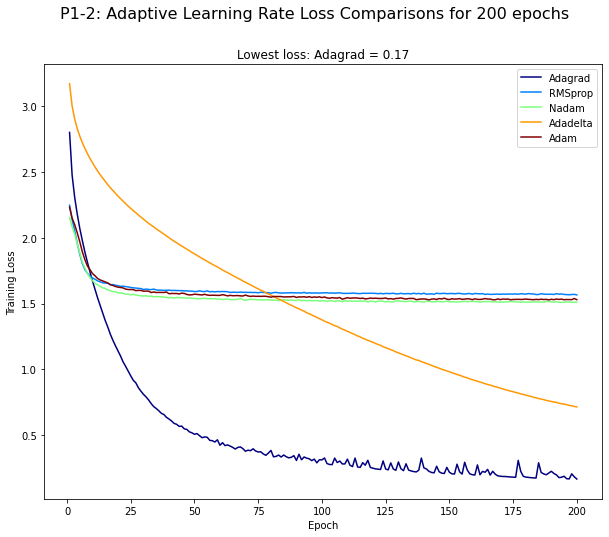

In [ ]:
# %tensorboard --logdir logs/fit

# plot the loss
title = "P1-2: Adaptive Learning Rate Loss Comparisons for {} epochs".format(n_epochs)
plotPerformance(perf['Q1_2'],title,plot_type='train_loss')

## 1.3: Add dropout (0.2 probability for input, 0.5 probability for hidden layers) and compare to 1.2:

__Answer: As can be seen in the plots below, (i) $\boxed{\textbf{AdaGrad}}$ performed the best in regards to training loss performance (left) while (ii) the methods with dropout appear to have the fastest training time (right) as expected. (This is the best training and validation loss I could achieve with the optimizer choosen and hyperparameters chosen.)__ 

In [ ]:
####
# Build, Train, Test, Report
####
print("\nRunning system...")
pname = 'Q1_3'
perf[pname] = {}
for method,lr,l2 in methods:
    # extend the performance dict
    method_p = method+'_dropout' # add dropout to the name
    perf[pname][method_p] = {}

    # define adpative learning rate method
    optimizer = getMethod(method,lr)

    # define regularizer
    regularizer = regularizers.l2(l2=l2)

    # tensorboard log dir
    dt = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = log_top.format(pname,method,dt)
    tf.get_logger().setLevel('ERROR') # turn off tf warnings

    # run on GPU
    with tf.device('/device:GPU:0'):
      #### 
      # Build/Compile the network
      ####
      model = buildModel(input_shape, n_units, n_hidden_layers, n_classes,
                         regularizer, optimizer, dropout=True)
      ####
      # Training/Testing
      ####
      perf[pname][method_p] = runModel(model, x_train, y_train,
                                      x_test, y_test, 
                                      batch_size, n_epochs,
                                       log_dir=log_dir)

print("\nDone!")
tf.get_logger().setLevel('INFO') # turn on tf warnings


Running system...
> Trained with 'Adagrad' (epochs=200, loss=1.47, acc=54.91%, time=401.86s)...
>> Layers: | flatten | dropout | dense | dropout | activation | dense | dropout | activation | dense |

> Trained with 'RMSprop' (epochs=200, loss=1.87, acc=39.20%, time=467.25s)...
>> Layers: | flatten | dropout | dense | dropout | activation | dense | dropout | activation | dense |

> Trained with 'Nadam' (epochs=200, loss=1.87, acc=40.68%, time=597.55s)...
>> Layers: | flatten | dropout | dense | dropout | activation | dense | dropout | activation | dense |

> Trained with 'Adadelta' (epochs=200, loss=1.79, acc=42.68%, time=426.31s)...
>> Layers: | flatten | dropout | dense | dropout | activation | dense | dropout | activation | dense |

> Trained with 'Adam' (epochs=200, loss=1.88, acc=39.67%, time=387.94s)...
>> Layers: | flatten | dropout | dense | dropout | activation | dense | dropout | activation | dense |


Done!


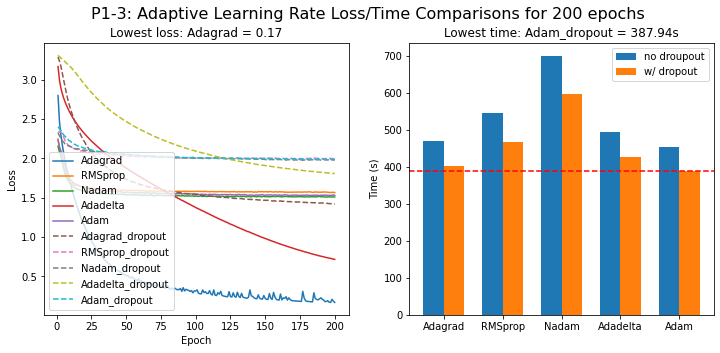

In [ ]:
#%tensorboard --logdir logs/fit

tmp2 = perf['Q1_2']
tmp3 = perf['Q1_3']

#####
# performance plots
#####
fig2 = plt.figure(figsize=(12,5))
title = "Adaptive Learning Rate Loss/Time Comparisons for {} epochs".format(n_epochs)
fig2.suptitle('P1-3: {}'.format(title), fontsize=16)
ax1 = fig2.add_subplot(1, 2, 1)
cmap = plt.cm.get_cmap('jet', len(methods)*2)

legend = []
loss = []
time =[]
times = []
for k in perf:
  tmp = perf[k]
  # best loss
  loss.extend([(x,np.min(tmp[x]['fit_loss'])) for x in tmp])
  # fastest training time
  time.append([tmp[x]['fit_time'] for x in tmp])
  times.extend([(x,tmp[x]['fit_time']) for x in tmp])
  # plot
  legend.extend(list(tmp.keys()))
  # plotting loss for each method
  for i,method in enumerate(tmp.keys()):
    line_type = '--' if method.endswith('dropout') else '-'
    ax1.plot([None] + tmp[method]['fit_loss'],line_type)#,c=cmap(i))

best = min(loss,key=lambda t: t[1])
ax1.set_title("Lowest loss: {} = {:.2f}".format(best[0],best[1]))
ax1.legend(legend, loc= 0)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')


#####
# Timing charts
#####
# fastest training time
best_time= min(times,key=lambda t: t[1])
ind = np.arange(len(methods)) 
width = 0.35   
# plot
ax2 = fig2.add_subplot(1, 2, 2)
ax2.set_title("Lowest time: {} = {:.2f}s".format(best_time[0],best_time[1]))
ax2.bar(ind, time[0], width, label='no droupout')
ax2.bar(ind + width, time[1], width, label='w/ dropout')
ax2.axhline(best_time[1],color='r', linestyle='--')
ax2.legend(loc= 'best')
ax2.set_xticks(ind + width / 2)
ax2.set_xticklabels([x[0] for x in methods])
ax2.set_ylabel('Time (s)')
plt.show()

## 1.4: Compare test accuracy of trained model (Keras takes care of weight scales):  

__Answer: As can be seen below, the test accuracy from the AdaGrad method appears to be the best (\~55%), while the test accuracy for RMSprop with dropout is the worst (\~40%). As mentioned above, these are the best test accuracies I was able to achieve rnuning in Colab; whereas, Brandon was able to achieve better performance running the same code.__

_Note: Adadelta with dropout appears to have moment from epoch 10 to about epcoh 25 where the accuracy actually diverges. This could likely be fixed with adjusting the hyperparameters for that method; however, due to time constraints I was not able to tune that method._

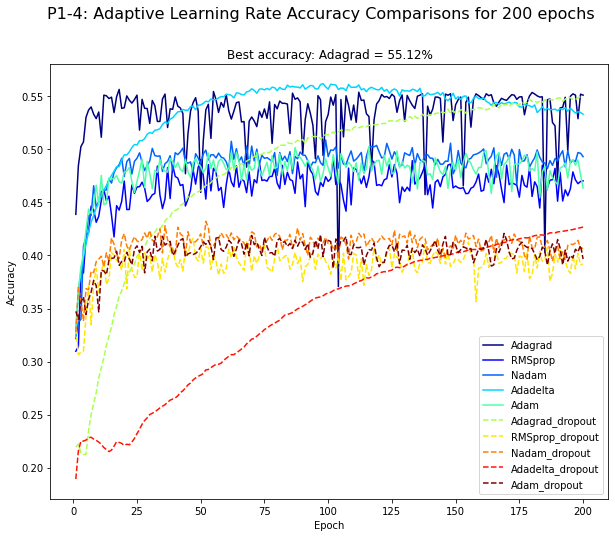

In [ ]:
#####
# performance plots (accuracy)
#####
# best
acc2 = [(x,tmp2[x]['eval_accuracy']) for x in tmp2]
acc3 = [(x,tmp3[x]['eval_accuracy']) for x in tmp3]
best= max(acc2+acc3,key=lambda t: t[1])
# plot
cmap = plt.cm.get_cmap('jet', len(methods)*2)
fig2 = plt.figure(figsize=(10,8))
title = "Adaptive Learning Rate Accuracy Comparisons for {} epochs".format(n_epochs)
fig2.suptitle('P1-4: {}'.format(title), fontsize=16)
# plotting loss for each method
ax1 = fig2.add_subplot(1, 1, 1)
ax1.set_title("Best accuracy: {} = {:.2f}%".format(best[0],best[1]*100))
for i,method in enumerate(tmp2.keys()):
  ax1.plot([None] + tmp2[method]['val_accuracy'],'-',c=cmap(i))
for i,method in enumerate(tmp3.keys()):
  ax1.plot([None] + tmp3[method]['val_accuracy'],'--',c=cmap(i+len(methods)))
ax1.legend(list(tmp2.keys())+list(tmp3.keys()), loc= 0)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
plt.show()

***
# Problem 3: Convolutional Neural Networks Architectures (30)
The following references will be used for this problem:   
> [1] Krizhevsky et. al., "ImageNet Classification with Deep Convolutional Neural Networks"   
> [2] https://cs231n.github.io/convolutional-networks/   
> [3] Simonyan et al., "Very Deep Convolutional Networks for Large-scale Image Recognition"   
> [4]  Szegedy et al., "Going deeper with convolutions"


## 3.1: AlexNet

The Alexnet architecture is as follows (per Section 3.4 of [1]):
> * __Input:__ Image size 224 x 224 x 3 (See Note 1)  
* __Layer 1:__ 96 kernels of size 11 x 11 x 3, Stride 4, Pad 0 (per [2])  
* __Max pooling:__ 3x3, Stride 2 (Section 3.4)   
* __Layer 2:__ 256 kernels of size 5 x 5 x 48, Stride 1, Pad 2
* __Max pooling:__ 3x3, Stride 2 (Section 3.4)   
* __Layer 3:__ 384 kernels of size 3 x 3 x 256, Stride 1, Pad 1
* __Layer 4:__ 384 kernels of size 3 x 3 x 192, Stride 1, Pad 1
* __Layer 5:__ 256 kernels of size 3 x 3 x 192, Stride 1, Pad 1   
* __Max pooling:__  3x3, Stride 2 (Section 3.4)     
* __Layer 6:__ 4096 fully connected   
* __Layer 7:__ 4096 fully connected
* __Layer 8:__ 1000 fully connected (softmax)   

_Note 1: that many sources (e.g., https://cs231n.github.io/convolutional-networks/) claim that the input image size should actually be 227x227x3 for the ConvNet to be valid._   


For the parameter calculations we will assume parameter sharing (per [2]) and ignore bias (per Piazza @255). Moreover, from [2] we know that the equations for convolution layers are
$$
W(idth)_{conv} = \frac{W(idth)_{in} - F(ilters) + 2 \cdot P(adding)}{S(tride)} + 1
$$
   
$$
D(epth)_{conv} = K(ernels)
$$    

$$
Params = K(ernels) \cdot F(ilters) \cdot F(ilters) \cdot D(epth)_{in} 
$$   

and the equations for pooling layers are

$$
W(idth)_{pool} = \frac{W(idth)_{conv} - F(ilters)}{S(tride)} + 1
$$

$$
D(epth)_{pool} = D(epth)_{conv}
$$

Therefore, the parameter calculations for each layer are
> * __Layer 1:__ $W_{I} = 227$, $D_{I} = 3$, $K = 96$, $S = 4$, $F = 11$, $P = 0$
    * $W_{O1} = (227 - 11 + 2\cdot0)/4 + 1 = 55$
    * $D_{O1} = K = 96$
    * $Parms_{1} = 96 \cdot 11 \cdot 11 \cdot 3 = \boxed{\textbf{34,848}}$   
* __Max pooling:__ $S = 2$, $F = 3$ (per [2])
    * $W^{p}_{O1} = (55-3)/2+1 = 27$ 
    * $D^{p}_{O1} = D_{O1} = 96$
* __Layer 2:__ $W_{I} = 27$, $D_{I} = 96/2$, $K = 256$, $S = 1$, $F = 5$, $P = \lfloor F/2 \rfloor = 2$
    * $W_{O2} = (27 - 5 + 2\cdot2)/1 + 1 = 27$
    * $D_{O2} = K = 256$
    * $Parms_{2} = 256 \cdot 5 \cdot 5 \cdot 48 = \boxed{\textbf{307,200}}$   
* __Max pooling:__ $S = 2$, $F = 3$
    * $W^{p}_{O2} = (27-3)/2+1 = 13$ 
    * $D^{p}_{O2} = D_{O2} = 256$
* __Layer 3:__ $W_{I} = 13$, $D_{I} = 256$, $K = 384$, $S = 1$, $F = 3$, $P = \lfloor F/2 \rfloor = 1$
    * $W_{O3} = (13 - 3 + 2\cdot1)/1 + 1 = 13$
    * $D_{O3} = K = 384$
    * $Parms_{3} = 384 \cdot 3 \cdot 3 \cdot 256 = \boxed{\textbf{884,736}}$   
* __Layer 4:__ $W_{I} = 13$, $D_{I} = 384/2 = 192$, $K = 384$, $S = 1$, $F = 3$, $P = \lfloor F/2 \rfloor = 1$
    * $W_{O4} = (13 - 3 + 2\cdot1)/1 + 1 = 13$
    * $D_{O4} = K = 384$
    * $Parms_{4} = 384 \cdot 3 \cdot 3 \cdot 192 = \boxed{\textbf{663,552}}$   
* __Layer 5:__ $W_{I} = 13$, $D_{I} = 384/2 = 192$, $K = 256$, $S = 1$, $F = 3$, $P = \lfloor F/2 \rfloor = 1$
    * $W_{O5} = (13 - 3 + 2\cdot1)/1 + 1 = 13$
    * $D_{O5} = K = 256$
    * $Parms_{5} = 256 \cdot 3 \cdot 3 \cdot 192 = \boxed{\textbf{442,368}}$ 
* __Max pooling:__  $S = 2$, $F = 3$
    * $W^{p}_{O5} = (13-3)/2+1 = 6$ 
    * $D^{p}_{O5} = D_{O5} = 256$
* __Layer 6:__ $W_{I} = 6$, $D_{I} = 256$, $K = 4096$ (per [2])
    * $W_{O6} = 1$
    * $D_{O6} = 4096$
    * $Parms_{6} = 4096 \cdot 6 \cdot 6 \cdot 256 = \boxed{\textbf{37,748,736}}$ 
* __Layer 7:__ $W_{I} = 1$, $D_{I} = 4096$, $K = 4096$ (per [2])
    * $W_{O7} = 1$
    * $D_{O7} = 4096$
    * $Parms_{7} = 4096 \cdot 1 \cdot 1 \cdot 4096 = \boxed{\textbf{16,777,216}}$   
* __Layer 8:__ $W_{I} = 1$, $D_{I} = 4096$, $K = 1000$ (per [2])
    * $W_{O8} = 1$
    * $D_{O8} = 4096$
    * $Parms_{8} = 1000 \cdot 1 \cdot 1 \cdot 4096 = \boxed{\textbf{4,096,000}}$   

Therefore, the total number of parameters in AlexNet is: $\boxed{\textbf{60,954,656}}$



## 3.2 VGG
The table below provides all of the calculations for the VGG19 architecure (including the pre-populated values)

|Layer    |Number of Activations (Memory)|Parameters (Compute)&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
|---------|------------------------------|--------------------|
|Input    |$224*224*3=150K$       |$0$|
|CONV3-64 |$224*224*64=3.2M$      |$(3*3*3)*64=1,728$ |
|CONV3-64 |$224*224*64=3.2M$      |$(3*3*64)*64=36,864$ |
|POOL2    |$112*112*64=800K$      |$0$ | 
|CONV3-128|$112*112*128=1.6M$	    |$(3*3*64)*128=73,728$	|
|CONV3-128|$112*112*128=1.6M$	    |$(3*3*128)*128=147,456$|
|POOL2    |$56*56*128=400K$       |$0$|
|CONV3-256|$56*56*256=800K$	      |$(3*3*128)*256=294,912$|
|CONV3-256|$56*56*256=800K$       |$(3*3*256)*256=589,824$|
|CONV3-256|$56*56*256=800K$       |$(3*3*256)*256=589,824$|
|CONV3-256|$56*56*256=800K$       |$(3*3*256)*256=589,824$|
|POOL2    |$28*28*256=200K$		    |$0$|
|CONV3-512|$28*28*512=400K$       |$(3*3*256)*512=1,179,648$|
|CONV3-512|$28*28*512=400K$		    |$(3*3*512)*512=2,359,296$|
|CONV3-512|$28*28*512=400K$ 	    |$(3*3*512)*512=2,359,296$|
|CONV3-512|$28*28*512=400K$		    |$(3*3*512)*512=2,359,296$|
|POOL2    |$14*14*512=100K$ 	    |$0$|	
|CONV3-512|$14*14*512=100K$	      |$(3*3*512)*512=2,359,296$|
|CONV3-512|$14*14*512=100K$	      |$(3*3*512)*512=2,359,296$|	
|CONV3-512|$14*14*512=100K$	      |$(3*3*512)*512=2,359,296$|	
|CONV3-512|$14*14*512=100K$	      |$(3*3*512)*512=2,359,296$|	
|POOL2    |$7*7*512=25K$	        |$0$|	
|FC       |$4096$	                |$4096*7*7*512=102,760,448$|
|FC       |$4096$ 	              |$4096*4096=16,777,216$|
|FC       |$1000$	                |$4096*1000=4,096,000$|
|$\textbf{TOTAL}$|$\textbf{16.5M}$|$\textbf{143,652,544}$	|




## 3.3: VGG + AlexNet

From Leture 6 slides we know that the output activation map length (receptive field) is defined as: $L-F+1$. This can also be easily derived from the equation provided in [2] where the convolutional filter is applied with $P=0$ and $S=1$: 
$$
W_{O} = \frac{W_{I} - F + 2 \cdot (P=0)}{(S=1)} + 1 = W_{I}-F+1
$$

We can then derive a formula for $N$ stacked convolutions with filter size $FxF$ simply by expanding the equation over $3$ stacked layers (similar to what was covered in class):
$$
\begin{align}
W_{O1} &= W_{I}-F+1 \\
W_{O2} &= W_{O1}-F+1 = (W_{I}-F+1)-F+1 = W_{I}-2F+2 \\
W_{O3} &= W_{O2}-F+1 = (W_{I}-2F+2)-F+1 = W_{I}-3F+3
\end{align}
$$

It is clear that the receptive field equation for N stacked convolutions becomes:  
$$
W_{ON} = W_{I}-NF+N
$$  

Similarly, for a single convolutional layer with filter size $(NF-N+1)\text{ x }(NF-N+1)$ we can find the output receptive field the same way as the first convolutional layer above with $F=NF-N+1$:  
$$
W_{O1}^{'} = W_{I}-(NF-N+1)+1 = W_{I}-NF+N
$$ 

Therefore, it is clear that $\boxed{W_{ON} = W_{O1}^{'}}$ as desired!  

For a stack of $3$ convolutional filters of size $5\text{ x } 5$ we can calculate the receptive field using the equation for $W_{ON}$ above, such that:
$$
\boxed{W_{O3} = W_{I}-3\cdot5+3 = W_{I}-12}
$$

## 3.4: Googlenet & Inception Model
### 3.4(a) 
As stated in lecture and confirmed in [4], the main idea of the Inception architecture is that the convolutional filters of different sizes preserve the local and sparse correlations from "readily available dense components". All while decreasing the computational complexity when significantly increasing the number of units per stage through __dimension reudction__ [4].  

### 3.4(b)
For these calculations the standard equations will be used:
$$
ConvOuput = W_{O} \text{ x } W_{O} \text { x } D_{O}
$$
where, 
$$
W_{O} = \frac{W_{I} - F + 2\cdot P}{S} + 1 \text{ and } D_{O} = K
$$
Note, for Max Pool layers $D_{O} = D_{I}$.  

For each of these calculations, we assume the stride ($S$) is $1$ and that padding is used to maintain the output dimensions for concatenation (Piazza @222). To calculate the padding for each convolution, the following equation is used (from [2]):

$$
P = (F-1)/2
$$
Note 1: $F$ is typically odd for CNNs which is why the equation above is sufficient; however, $P = \lfloor F/2 \rfloor$ is equavilent to the above and works for even filter sizes as well.  

Therefore, it is easy to see that $W_{O}$ simplifies to:
$$
W_{O} = \frac{W_{I} - F + 2\cdot (F-1)/2}{1} + 1  \Rightarrow W_{O} = W_{I}
$$  

For brevity, all calculations below were made using the equations above; moreover, only the sensitive variables are included for each result (knowing that padding was used to maintain output dimensions as shown above and stride is one). 

__Naive:__   
The following table provides the resulting output from each convolution and max pooling module. Below the table is the final concatenation calculation.

| Layer 1 | Layer 2  | 
|---|:-:|  
|Conv(#"1x1", $W_{I} = 32$, $K=128$) $\rightarrow \textbf{32 x 32 x 128}$ | n/a |
|Conv(#"3x3", $W_{I} = 32$, $K=192$) $\rightarrow \textbf{32 x 32 x 192}$| n/a |  
|Conv(#"5x5", $W_{I} = 32$, $K=96$) $\rightarrow \textbf{32 x 32 x 96}$| n/a |
|MaxPool("3x3", $W_{I} = 32$, $D_{I}=256$) $\rightarrow \textbf{32 x 32 x 256}$| n/a |

Contcat(#"1x1", #"3x3", #"5x5", MaxPool("3x3")) $\rightarrow  \boxed{\textbf{32 x 32 x 672}}$
* Concat = $32 \text{ x } 32 \text{ x } (128+192+96+256)$   

__Inception:__   
The following table provides the resulting output from each convolution and max pooling module. Below the table is the final concatenation calculation.

| Layer 1| Layer 2  | 
|---|---|  
|Conv(#"1x1", $W_{I} = 32$, $K=128$) $\rightarrow \textbf{32 x 32 x 128}$ | <center>n/a</center> |
|Conv(R3"1x1", $W_{I} = 32$, $K=128$) $\rightarrow \textbf{32 x 32 x 128}$ | Conv(#"3x3", $W_{I} = 32$, $K=192$) $\rightarrow \textbf{32 x 32 x 192}$ |  
|Conv(R5"1x1", $W_{I} = 32$, $K=32$) $\rightarrow \textbf{32 x 32 x 32}$| Conv(#"5x5", $W_{I} = 32$, $K=96$) $\rightarrow \textbf{32 x 32 x 96}$|
| MaxPool("3x3", $W_{I} = 32$, $D_{I}=256$) $\rightarrow \textbf{32 x 32 x 256}$ | Conv(RM"1x1", $W_{I} = 32$, $K=64$) $\rightarrow \textbf{32 x 32 x 64}$ |

Contcat(#"1x1", #"3x3", #"5x5", RM"3x3") $\rightarrow  \boxed{\textbf{32 x 32 x 480}}$
* Concat = $32 \text{ x } 32 \text{ x } (128+192+96+64)$   

### 3.4(c)  
For the operations of each of the inception architectures, the tables above will be used for reference and will not be copied. __Per Piazza @247, the Max Pooling layers will be ignored for these calculations.__ Finally, [2] and [4] were used as guides for calculating the number of operations.

__Naive:__   

The total number of operations for the naive architecture is $\approx \boxed{\textbf{1.1B}}$, as calculated below.

* $32x32x256 \rightarrow \frac{\text{1 x 1}}{\text{128}}\rightarrow 32x32x128$ 
    * $\Rightarrow (32*32*128)\text{x}(1*1*256) = \textbf{33,554,432}$

* $32x32x256 \rightarrow \frac{\text{3 x 3}}{\text{192}}\rightarrow 32x32x192 $
    * $\Rightarrow (32*32*192)\text{x}(3*3*256) = \textbf{452,984,832}$

* $32x32x256 \rightarrow \frac{\text{5 x 5}}{\text{96}}\rightarrow 32x32x96 $
    * $\Rightarrow (32*32*96)\text{x}(5*5*256) = \textbf{629,145,600}$

__Inception:__   

The total number of operations for the inception architecture is $\approx \boxed{\textbf{397M}}$, as calculated below.

* $32x32x256 \rightarrow \frac{\text{1 x 1}}{\text{128}}\rightarrow 32x32x128$ 
    * $\Rightarrow (32*32*128)\text{x}(1*1*256) = \textbf{33,554,432}$

* $32x32x256 \rightarrow \frac{\text{1 x 1}}{\text{128}}\rightarrow 32x32x128 \rightarrow \frac{\text{3 x 3}}{\text{192}}\rightarrow 32x32x192 $
    * $\Rightarrow (32*32*128)\text{x}(1*1*256) = \textbf{33,554,432}$
    * $\Rightarrow (32*32*192)\text{x}(3*3*128) = \textbf{226,492,416}$

* $32x32x256 \rightarrow \frac{\text{1 x 1}}{\text{32}}\rightarrow 32x32x32 \rightarrow \frac{\text{5 x 5}}{\text{96}}\rightarrow 32x32x96 $
    * $\Rightarrow (32*32*32)\text{x}(1*1*256) = \textbf{8,388,608}$
    * $\Rightarrow (32*32*96)\text{x}(5*5*32) = \textbf{78,643,200}$

* $32x32x256 \rightarrow \text{MaxPool} \rightarrow 32x32x256 \rightarrow \frac{\text{1 x 1}}{\text{64}}\rightarrow 32x32x64 $
    * $\Rightarrow$ Ignore max pooling
    * $\Rightarrow (32*32*64)\text{x}(1*1*256) = \textbf{16,777,216}$

### 3.4(d) 
It is clear from the calculations in 3.4(c) that the computational complexity blows-up when the convolution is exposed directly with the output. However, with the Inception architcure the problem with the naive solution is resolved by first convolving the input with a 1x1 filter to reduce dimensionality.   

The computational savings by choosing the Inception architecture over a naive one is $\approx \boxed{36\%}$.

***
# Problem 4: Batch Augmentation, Cutout Regularization (20)

The following references will be used for this problem:   
> [1] DeVries et al. Improved Regularization of Convolutional Neural Networks with Cutout.
> * Paper available at https://arxiv.org/pdf/1708.04552.pdf
> * Code available at https://github.com/uoguelph-mlrg/Cutout   
> 
> [2] Hoffer et al. Augment your batch: better training with larger batches. 2019
> * Paper available at https://arxiv.org/pdf/1901.09335.pdf
> * Code available at https://github.com/eladhoffer/convNet.pytorch/tree/master/models 
> 
> [3] He et al. Deep residual learning for image recognition.
> * Paper available at https://arxiv.org/abs/1512.03385
>
> [4] https://github.com/akamaster/pytorch_resnet_cifar10



In [11]:
# RUN THIS BEFORE EXECUTING CODE FOR PORBLEM 4

# Should make training should go faster for large models
cudnn.benchmark = True  

# for repeatability
seed = 88
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Global vars
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 
              'dog', 'frog', 'horse', 'ship', 'truck']

best_prec1 = 0
global args, best_prec1

############   
# all of these functions are included from [4]
def train(train_loader, model, criterion, optimizer, epoch,print_freq=50):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        input_var = input.cuda()
        target_var = target
        # if args.half:
            # input_var = input_var.half()

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # if i % print_freq == 0:
        if i == len(train_loader)-1:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
            
            
def validate(val_loader, model, criterion,print_freq=50):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # if args.half:
            #     input_var = input_var.half()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # if i % print_freq == 0:
            if i == len(val_loader)-1:
                print('Test:  [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    # print(' * Prec@1 {top1.avg:.3f}'
    #       .format(top1=top1))

    return top1.avg, losses.avg

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res
# end [4] functions
############   

# Check the save_dir exists or not
save_dir = '/content/gdrive/My Drive/Colab Notebooks/prob4_data'
if not os.path.exists(save_dir):
        os.makedirs(save_dir)

## 4.1 Cutout regularization demo

First, it is important to recall that dropout "stochastically drops [intermediate] neuron activations during training and as a result discourages the co-adaptation of feature detectors" [1]. Furthermore, those activations can be thought of as individual pixels. On the other hand, according to [1], cutout regularization drops units only at the input layer of a CNN (rather than in the intermediate feature layers) and those units are contiguous blocks of pixels (rather than individual pixels). Moreover, the authors state that these "cutouts" apply to all subsequent stages, effectively removing the information from associated feature maps.  

__From this, it is fairly clear that cutout would de-emphasize information for all neurons, especially high-freqeuncy information that could cause a model to not generalize well. Dropout, on the other hand, may not de-emphasize key visual features very well since it is only dropping individual neurons (pixels) which will most likely not be enough to keep a model from focusing in on the high-frequency information included in the neighboring pixels and other (earlier and deeper) neurons.__ 

The following code is an example of using cutout regularization. The code is provided open-source in [1].


Preparing data...


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


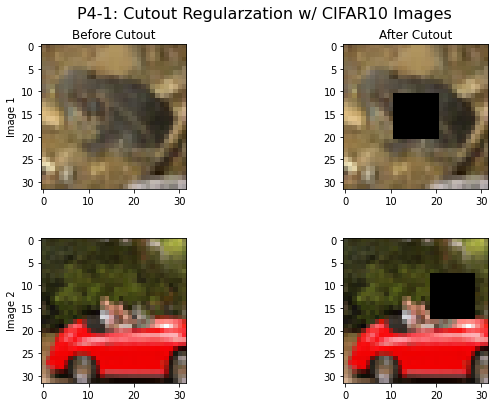

In [6]:
####
# Prepare data
####
print("\nPreparing data...") 

############   
# from [1] source code
# train transform
cut_transform = transforms.Compose([transforms.ToTensor(),
                                    Cutout(n_holes=1, 
                                            length=10)])
# test transform
raw_transform = transforms.Compose([transforms.ToTensor()])

# data used to show original image
raw_dataset = datasets.CIFAR10(root='data/',
                                  train=True,
                                  transform=raw_transform,
                                  download=True)
raw_loader = torch.utils.data.DataLoader(dataset=raw_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           pin_memory=True,
                                           num_workers=2)
# data used to show cutout image
cut_dataset = datasets.CIFAR10(root='data/',
                                  train=True,
                                  transform=cut_transform,
                                  download=True)
cut_loader = torch.utils.data.DataLoader(dataset=cut_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           pin_memory=True,
                                           num_workers=2)
############
im1 = 23
im2 = 99   
# get raw & cut image from dataloaders
raw, _ = next(iter(raw_loader)) 
cut, _ = next(iter(cut_loader)) 
# put into right dtype & shape for imshow()
rawimg1 = np.transpose(raw[im1].numpy(), (1,2,0))
cutimg1 = np.transpose(cut[im1].numpy(), (1,2,0))
rawimg2 = np.transpose(raw[im2].numpy(), (1,2,0))
cutimg2 = np.transpose(cut[im2].numpy(), (1,2,0))

title = r"Cutout Regularzation w/ CIFAR10 Images"
fig4 = plt.figure(figsize=(10,6))
fig4.suptitle('P4-1: {}'.format(title), fontsize=16)
# plotting 1st image
ax1 = fig4.add_subplot(2, 2, 1)
ax1.set_title(r"Before Cutout")
ax1.set_ylabel('Image 1')
ax1.imshow(rawimg1) 
ax2 = fig4.add_subplot(2, 2, 2)
ax2.set_title(r"After Cutout")
ax2.imshow(cutimg1) 
# plotting 2nd image
ax3 = fig4.add_subplot(2, 2, 3)
# ax3.set_title(r"Image 2 Before Cutout")
ax3.set_ylabel('Image 2')
ax3.imshow(rawimg2) 
ax4 = fig4.add_subplot(2, 2, 4)
# ax4.set_title(r"Image 2 After Cutout")
ax4.imshow(cutimg2) 
plt.tight_layout(pad=3.0)
plt.show()

## 4.2 CIFAR10 datasest and Resnet-44 w/ He et. al. augmentation 

As shown in Piazza, for this problem the open source Cifar10 Resnet-44 github repository was used:  
https://github.com/akamaster/pytorch_resnet_cifar10   

The Resnet-44 architecure that is implemented from the source above includes batch normalization with no dropout, which is what He et. al. implements and, thus, Hoffer et. al. also implement. Morover, Hoffer et. al. use a weight decay of 0.0001, momentum of 0.9, initial learning rate of 0.1 (decayed by 10 every 32k and 48k iterations w/ batch size of 128), max iterations of 64k (~82 epochs), and SGD. All of these are considered in the implementation below.


Preparing data...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


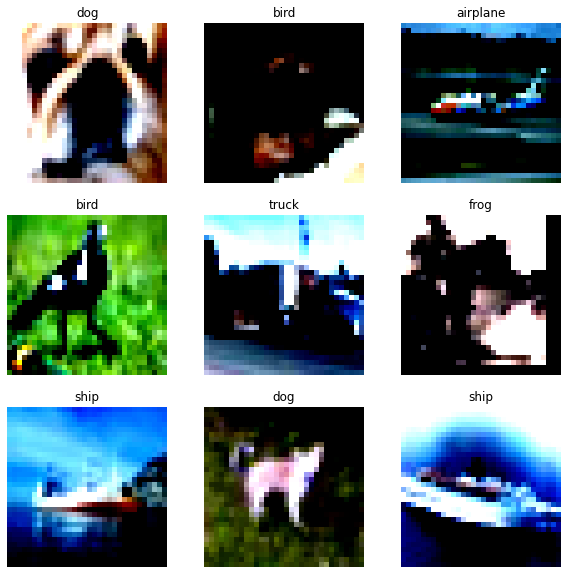

In [7]:
# Clear any logs from previous runs (for tensorboard)
# !rm -rf ./logs/ 
# log_top = "logs/fit/{}-{}_{}"

# prepare the model
arch = 'resnet44'
model = torch.nn.DataParallel(resnet.__dict__[arch]())
model.cuda()
cudnn.benchmark = True

# load the model (if loading, set startin epoch)
start_epoch = 0 # replace with starting epoch
if start_epoch > 0:
    evaluate = True
    # resume from checkpoint if Colab booted us during training
    resume = os.path.join(save_dir,'p42_E{}_checkpoint.th'.format(start_epoch))
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(evaluate, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))
    
####
# Hyperparameters
####
cifar10_size = 50000
batch_size = 64
n_iters = 50000/batch_size #  
momentum = 0.9
weight_decay = 0.0001
lr = 0.1 # divide by 10 at 32k and 48k iterations (for 128 batch size!)
lr_decay = 0.1
lr_decay_at = [np.floor(32000/n_iters),
              np.floor(48000/n_iters)]
epochs = np.floor(64000/n_iters) # stop after 64000 iters
epoch_max = 100 # per assignment, no more than 100 epochs


####
# Create the model
####
# normalize the input (from [4] source code)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
############   

############   
# from [1] source code
####
# Prepare data
####
print("\nPreparing data...") 

# train/test transform
plain_transform = transforms.Compose([
                          transforms.ToTensor(),
                          normalize])

# augmented data
# data augmentation per He et. al. (i.e., pad 4 pixels, random crop, h-flip)
aug_transform = transforms.Compose([
                          transforms.RandomHorizontalFlip(),
                          transforms.RandomCrop(32, padding=4),
                          transforms.ToTensor(),
                          normalize])

# training data (no augmentation)
train_dataset = datasets.CIFAR10(root='data/',
                                  train=True,
                                  transform=plain_transform,
                                  download=True)

# training data (w/ augmentation)
aug_dataset = datasets.CIFAR10(root='data/',
                                  train=True,
                                  transform=aug_transform,
                                  download=True)

# per Piazza @256 we need to append training set with some augmented data
# subsample augmented dataset (5000 samples)
idxs = np.random.choice(len(aug_dataset.data), 5000, replace=False)
aug_dataset.data = [aug_dataset.data[idx] for idx in idxs]
# concatenate the real training dataset with augmented images
# ref: https://discuss.pytorch.org/t/concatenation-while-using-data-loader/10772
train_dataset = torch.utils.data.ConcatDataset([train_dataset,aug_dataset])

# testing data (no cutout, original image)
test_dataset = datasets.CIFAR10(root='data/',
                                  train=False,
                                  transform=plain_transform,
                                  download=True)

# data loaders (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64,
                                           shuffle=False,
                                           pin_memory=True,
                                           num_workers=2)

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                              milestones=lr_decay_at, 
                                              gamma=lr_decay)#,
                                              # last_epoch=start_epoch-1)
lr_scheduler.last_epoch = start_epoch - 1

# peak at the augmented data
peak_size = 9
images,labels = next(iter(train_loader))
dsize = len(images)
idxs = np.random.choice(range(dsize), peak_size, replace=False)
# idxs = np.random.randint(0,dsize,peak_size)
imt,lbt = [images[i] for i in idxs],[labels[j] for j in idxs]
fig = plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(zip(imt,lbt)): # one batch
  # put into right dtype & shape for imshow()
  tmpimg = np.transpose(image.numpy(), (1,2,0))
  ax = fig.add_subplot(3, 3, i+1)
  plt.imshow(tmpimg)
  plt.title(CLASS_NAMES[label.numpy()])
  plt.axis('off')

In [10]:
save_every = 10
info_2 = {'loss': [], 'prec': [], 'train_time': [], 'val_time': []}
for epoch in range(start_epoch, epochs):

        print('Learning Rate: {:.5e}'.format(optimizer.param_groups[0]['lr']))

        # train for one epoch
        t0 = time.time()
        train(train_loader, model, criterion, optimizer, epoch)
        info_2['train_time'].append(np.around(time.time()-t0,3))
        
        lr_scheduler.step()

        # evaluate on validation set
        t0 = time.time()
        prec1, loss = validate(test_loader, model, criterion)
        info_2['val_time'].append(np.around(time.time()-t0,3))

        # keep track of validation error per epoch for plotting
        info_2['loss'].append(loss)
        info_2['prec'].append(prec1)
        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        if epoch > 0 and epoch % save_every == 0:
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
            }, is_best, filename=os.path.join(
                                  save_dir, 
                                  'p42_E{}_checkpoint.th'.format(epoch)))
            # dump the data for later
            json_file = os.path.join(save_dir,
                                     'p42_E{}_datadump.json'.format(epoch))
            with open(json_file, 'w') as fp:
              json.dump(info_2, fp)
        
        print()

# save the model
save_checkpoint({
    'state_dict': model.state_dict(),
    'best_prec1': best_prec1,
}, is_best, filename=os.path.join(save_dir, 'p42_model.th'))
# dump the data for later
with open(os.path.join(save_dir,'p42_final_datadump.json'), 'w') as fp:
    json.dump(info_2, fp)

Learning Rate: 1.00000e-01
Epoch: [20][859/860]	Time 0.087 (0.048)	Data 0.000 (0.000)	Loss 2.0174 (1.9749)	Prec@1 33.333 (30.458)
Test:  [156/157]	Time 0.022 (0.022)	Loss 1.3018 (1.5156)	Prec@1 62.500 (45.340)

Learning Rate: 1.00000e-01
Epoch: [21][859/860]	Time 0.029 (0.048)	Data 0.000 (0.000)	Loss 1.6840 (1.4485)	Prec@1 37.500 (48.684)
Test:  [156/157]	Time 0.008 (0.022)	Loss 1.4798 (1.1797)	Prec@1 43.750 (57.860)

Learning Rate: 1.00000e-01
Epoch: [22][859/860]	Time 0.027 (0.048)	Data 0.000 (0.000)	Loss 1.0084 (1.1420)	Prec@1 66.667 (59.840)
Test:  [156/157]	Time 0.007 (0.022)	Loss 0.6584 (0.9003)	Prec@1 75.000 (69.160)

Learning Rate: 1.00000e-01
Epoch: [23][859/860]	Time 0.028 (0.047)	Data 0.000 (0.000)	Loss 1.0544 (0.9651)	Prec@1 58.333 (66.500)
Test:  [156/157]	Time 0.007 (0.021)	Loss 0.6724 (0.8496)	Prec@1 75.000 (70.450)

Learning Rate: 1.00000e-01
Epoch: [24][859/860]	Time 0.035 (0.047)	Data 0.000 (0.000)	Loss 0.6125 (0.8480)	Prec@1 79.167 (70.458)
Test:  [156/157]	Time 0.00

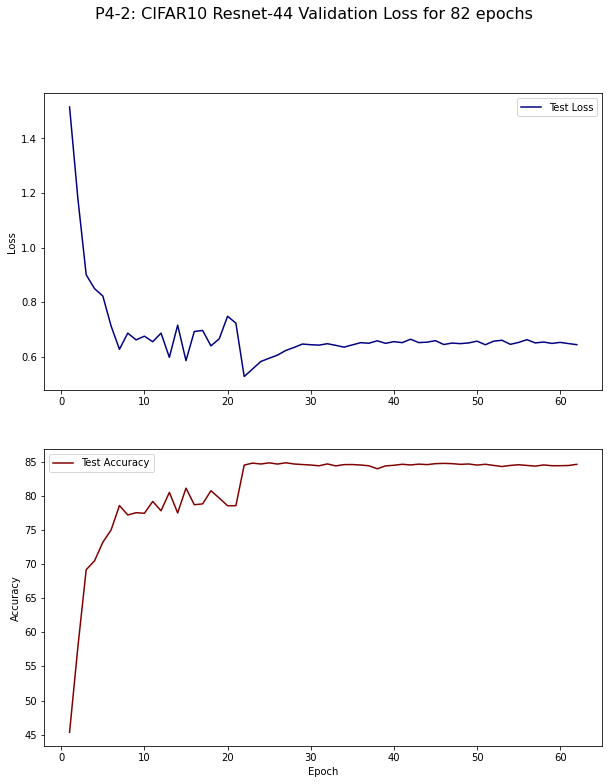

In [11]:
if info_2:
    plot_info = info_2
else:
    plot_info = {}
    for m in M:
      json_file = os.path.join(save_dir,'p43_M{}_datadump.json'.format(m))
      if os.path.isfile(json_file):
          with open(json_file) as json_file: 
              plot_info[m] = json.load(json_file) 
      else:
          print('File \'{}\' does not exist.'.format(json_file))

#####
# performance plots (loss)
#####
# plot
cmap = plt.cm.get_cmap('jet', 2)
fig2 = plt.figure(figsize=(10,12))
title = "CIFAR10 Resnet-44 Validation Loss for {} epochs".format(epochs)
fig2.suptitle('P4-2: {}'.format(title), fontsize=16)
# plotting loss for each method
ax1 = fig2.add_subplot(2, 1, 1)
# ax1.set_title("Best accuracy: {} = {:.2f}%".format(best[0],best[1]*100))
ax1.plot([None] + plot_info['loss'],'-',c=cmap(0),label='Test Loss')
ax2 = fig2.add_subplot(2, 1, 2)
ax2.plot([None] + plot_info['prec'],'-',c=cmap(1),label='Test Accuracy')
ax1.legend()
ax2.legend()
ax2.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
plt.show()

## 4.3 CIFAR10 datasest and Resnet-44 w/ cutout regularization
Simlar to 4.2, the hyperparameters used include weight decay of 0.0001, momentum of 0.9, initial learning rate of 0.1 (decayed by 10 every 32k and 48k iterations w/ batch size of 128), max iterations of 64k (~82 epochs), and the SGD optimizer. The difference is that cutout regularizaton is used in place of the He et. al. padding method. All of these are considered in the implementation below.

__Note: due to the duration this takes to run, I have manually restricted the max epochs to be 25 -- this was chosen because in Hofffer et. al. it claims that "[they] managed to achieve 94.15% accuracy in only 23 epochs."__  
__I ran out of time to complete this fully, but the plots below clearly show that M=16 provides the best loss (I realize that validation error was expected, but did not see this in time to complete it.) The plot is skewed due to failed epochs (seen beow).__

In [55]:
# Clear any logs from previous runs (for tensorboard)
# !rm -rf ./logs/ 
# log_top = "logs/fit/{}-{}_{}"

# prepare the model
arch = 'resnet44'
model = torch.nn.DataParallel(resnet.__dict__[arch]())
model.cuda()
cudnn.benchmark = True

# load a model (if loading from checkpoin, define start epoch/M)
start_epoch = 0 # replace with starting epoch
start_M = 0
if start_epoch > 0:
    evaluate = True
    # resume from checkpoint if Colab booted us during training
    resume = os.path.join(save_dir,'p42_E{}_checkpoint.th'.format(start_epoch))
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(evaluate, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

####
# Hyperparameters (more below in loop)
####
patch_len = 12 # length of the cutout (in pixels)
train_size = 50000
aug_size = 5000 # how many cutout images to include
epoch_max = 25 #100 #paper says ~23 epochs to 94%, assignment says <100 epochs

####
# PyTorch transorms used for training, testing, and augmenting
####   
# normalization parameters from [1]
normalize = transforms.Normalize(
                          mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                          std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

# train/test transform
plain_transform = transforms.Compose([
                          transforms.ToTensor(),
                          normalize])

# augmented data
# data augmentation per Hoffer et. al. (i.e., cutout)
aug_transform = transforms.Compose([
                          Cutout(n_holes=1, length=patch_len),
                          transforms.ToTensor(),
                          normalize])

####
# The Main Process
####
# create data and train/validate model for each M
final_display = '' # for final display
save_every = 5
info_3 = {}
start_batch_size = 64 #
M = [1,2,4,8,16] #,32] # save 32 for later... if I have time
for m in M:
    # on resume, start at last M
    if m >= start_M:  
        ####
        # Hyperparameters (cont.)
        ####
        batch_size = start_batch_size*m # increase B*M
        n_iters = np.ceil((train_size+aug_size*(m-1))/batch_size).astype('int') #  
        momentum = 0.9
        weight_decay = 0.0001
        lr = 0.1 # divide by 10 at 32k and 48k iterations (for 128 batch size!)
        lr_decay = 0.1
        lr_decay_at = [np.ceil(32000/n_iters).astype('int'),
                      np.ceil(48000/n_iters).astype('int')]
        epochs = np.ceil(64000/n_iters).astype('int') # stop after 64000 iters
        # data struct
        info_3[m] = {'batch_size': batch_size, 'loss': [], 'prec': [], 
                     'train_time': [], 'val_time': []}

        ####
        # Prepare data
        ####
        print("\n#############################".format(m)) 
        print("  Preparing data for M={}".format(m)) 
        print("#############################".format(m)) 
        ####################### OUTPUT ############################
        print(" >> Batch size:  {}".format(batch_size))
        print(" >> Num epochs:  {}".format(epochs))
        print(" >> Max epochs:  {}".format(epoch_max))
        ###########################################################  

        ############   
        # from [1] source code

        # training data (no cutout)
        train_dataset = datasets.CIFAR10(root='data/',
                                          train=True,
                                          transform=plain_transform,
                                          download=False)

        # create augmented data for each m (training data w/ cutout)
        for i in range(m-1):
            tmp = datasets.CIFAR10(root='data/',
                                   train=True,
                                   transform=aug_transform,
                                   download=False)
            # if we are subsampling, then randomly choose indices
            if aug_size < len(tmp):
                idxs = np.random.choice(len(tmp),aug_size, replace=False)
                tmp.data = [tmp.data[idx] for idx in idxs]
                tmp.targets = [tmp.targets[idx] for idx in idxs]

            # concatenate tue augmented data and targets
            data = np.concatenate([train_dataset.data, tmp.data], axis=0)
            tgts = np.concatenate([train_dataset.targets, tmp.targets], axis=0)
            train_dataset.data = data
            train_dataset.targets = tgts
                    
        # testing data (no cutout, original image)
        test_dataset = datasets.CIFAR10(root='data/',
                                          train=False,
                                          transform=plain_transform,
                                          download=False)

        # data loaders (input pipeline)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  pin_memory=True,
                                                  num_workers=2)

        test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                  batch_size=64,
                                                  shuffle=False,
                                                  pin_memory=True,
                                                  num_workers=2)
        
        print(" >> Training dataset size: {}".format(len(train_dataset)))
        print(" >> Testing dataset size:  {}".format(len(test_dataset)))


        # define loss function (criterion) and optimizer
        criterion = nn.CrossEntropyLoss().cuda()

        optimizer = torch.optim.SGD(model.parameters(), lr=lr,
                                        momentum=momentum,
                                        weight_decay=weight_decay)

        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=lr_decay_at, 
                                                      gamma=lr_decay)#,
        
        # pullled thisout of MultiStepLR due to errors
        lr_scheduler.last_epoch = start_epoch - 1

        # train and validate
        for epoch in range(start_epoch, epochs):

            print('Learning Rate: {:.5e}'.format(optimizer.param_groups[0]['lr']))

            # train for one epoch
            t0 = time.time()
            train(train_loader, model, criterion, optimizer, epoch)
            info_3[m]['train_time'].append(np.around(time.time()-t0,3))
            
            lr_scheduler.step()

            # evaluate on validation set
            t0 = time.time()
            prec1, loss = validate(test_loader, model, criterion)
            info_3[m]['val_time'].append(np.around(time.time()-t0,3))

            # keep track of validation error per epoch for plotting
            info_3[m]['loss'].append(loss)
            info_3[m]['prec'].append(prec1)
            # remember best prec@1 and save checkpoint
            is_best = prec1 > best_prec1
            best_prec1 = max(prec1, best_prec1)

            # checkpoints
            if epoch > 0 and epoch % save_every == 0:
                save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'best_prec1': best_prec1,
                }, is_best, filename=os.path.join(
                                  save_dir, 
                                  'p43_M{}_E{}_checkpoint.th'.format(m,epoch)))
                # dump the data for later
                json_file = os.path.join(save_dir,
                                'p43_M{}_E{}_datadump.json'.format(m,epoch))
                with open(json_file, 'w') as fp:
                  json.dump(info_3[m], fp)
            
            print()

            # once 94% accuracy is achieved or epoch max is reached, break
            if ((prec1 >= 94 and epoch >= 10) or (epoch >= epoch_max)):
                print('Reached max accuracy or max epoch\n')
                break

        # save the model
        save_checkpoint({
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best, filename=os.path.join(save_dir, 'M{}_model.th'.format(m)))
        
        # dump the data for later
        json_file = os.path.join(save_dir,
                                 'p43_M{}_datadump.json'.format(m))
        with open(json_file, 'w') as fp:
            json.dump(info_3[m], fp)
        



#############################
  Preparing data for M=1
#############################
 >> Batch size:  64
 >> Num epochs:  82
 >> Max epochs:  25
 >> Training dataset size: 50000
 >> Testing dataset size:  10000
Learning Rate: 1.00000e-01
Epoch: [0][781/782]	Time 0.035 (0.050)	Data 0.000 (0.000)	Loss 2.0835 (2.0505)	Prec@1 37.500 (24.194)
Test:  [156/157]	Time 0.008 (0.023)	Loss 1.3927 (1.5880)	Prec@1 43.750 (40.210)

Learning Rate: 1.00000e-01
Epoch: [1][781/782]	Time 0.029 (0.049)	Data 0.000 (0.000)	Loss 1.1509 (1.3932)	Prec@1 56.250 (48.838)
Test:  [156/157]	Time 0.007 (0.023)	Loss 1.3343 (1.3527)	Prec@1 37.500 (50.760)

Learning Rate: 1.00000e-01
Epoch: [2][781/782]	Time 0.029 (0.048)	Data 0.000 (0.000)	Loss 1.0592 (1.1010)	Prec@1 62.500 (60.668)
Test:  [156/157]	Time 0.009 (0.024)	Loss 1.0931 (0.9999)	Prec@1 75.000 (65.250)

Learning Rate: 1.00000e-01
Epoch: [3][781/782]	Time 0.031 (0.050)	Data 0.000 (0.000)	Loss 0.7513 (0.9012)	Prec@1 62.500 (68.498)
Test:  [156/157]	Time 0.009 (

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [0][166/167]	Time 0.031 (0.207)	Data 0.000 (0.002)	Loss 0.3345 (0.0005)	Prec@1 100.000 (100.000)
Test:  [156/157]	Time 0.007 (0.023)	Loss 14.6975 (10.0402)	Prec@1 31.250 (24.620)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [1][166/167]	Time 0.031 (0.204)	Data 0.000 (0.002)	Loss 0.1151 (0.7999)	Prec@1 100.000 (72.541)
Test:  [156/157]	Time 0.009 (0.023)	Loss 0.9018 (0.7260)	Prec@1 62.500 (74.910)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [2][166/167]	Time 0.031 (0.206)	Data 0.000 (0.003)	Loss 0.6641 (0.3997)	Prec@1 50.000 (86.119)
Test:  [156/157]	Time 0.007 (0.023)	Loss 1.2576 (1.5559)	Prec@1 62.500 (61.070)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
AssertionError: can only join a child process
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [3][166/167]	Time 0.031 (0.205)	Data 0.000 (0.002)	Loss 0.3598 (0.3443)	Prec@1 87.500 (88.234)
Test:  [156/157]	Time 0.009 (0.024)	Loss 1.5386 (1.3229)	Prec@1 62.500 (65.570)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [4][166/167]	Time 0.031 (0.205)	Data 0.000 (0.002)	Loss 0.2386 (0.2280)	Prec@1 87.500 (92.261)
Test:  [156/157]	Time 0.007 (0.025)	Loss 2.1060 (0.8736)	Prec@1 68.750 (77.020)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [5][166/167]	Time 0.031 (0.205)	Data 0.000 (0.002)	Loss 0.7946 (0.1563)	Prec@1 87.500 (94.720)
Test:  [156/157]	Time 0.008 (0.023)	Loss 3.0989 (1.8612)	Prec@1 37.500 (62.120)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [6][166/167]	Time 0.032 (0.204)	Data 0.000 (0.002)	Loss 0.4553 (0.3657)	Prec@1 75.000 (87.762)
Test:  [156/157]	Time 0.008 (0.023)	Loss 2.1153 (1.5140)	Prec@1 56.250 (66.380)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [7][166/167]	Time 0.031 (0.205)	Data 0.000 (0.002)	Loss 0.0431 (0.2660)	Prec@1 100.000 (91.001)
Test:  [156/157]	Time 0.007 (0.023)	Loss 1.3691 (0.7132)	Prec@1 68.750 (79.550)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [8][166/167]	Time 0.031 (0.205)	Data 0.000 (0.003)	Loss 0.0331 (0.0827)	Prec@1 100.000 (97.419)
Test:  [156/157]	Time 0.007 (0.024)	Loss 1.5844 (0.8804)	Prec@1 62.500 (78.860)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutd

Epoch: [9][166/167]	Time 0.031 (0.204)	Data 0.000 (0.002)	Loss 0.0221 (0.0520)	Prec@1 100.000 (98.372)
Test:  [156/157]	Time 0.007 (0.023)	Loss 0.4747 (0.9490)	Prec@1 81.250 (79.160)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [10][166/167]	Time 0.032 (0.205)	Data 0.000 (0.003)	Loss 0.2390 (0.0265)	Prec@1 87.500 (99.244)
Test:  [156/157]	Time 0.008 (0.023)	Loss 2.2190 (1.2907)	Prec@1 68.750 (75.670)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/u

Epoch: [11][166/167]	Time 0.032 (0.206)	Data 0.000 (0.003)	Loss 0.0833 (0.2173)	Prec@1 100.000 (92.888)
Test:  [156/157]	Time 0.007 (0.023)	Loss 0.4604 (0.7552)	Prec@1 81.250 (80.960)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [12][166/167]	Time 0.039 (0.205)	Data 0.000 (0.003)	Loss 0.3923 (0.0728)	Prec@1 75.000 (97.612)
Test:  [156/157]	Time 0.009 (0.024)	Loss 1.2805 (1.0492)	Prec@1 50.000 (76.330)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [13][166/167]	Time 0.032 (0.205)	Data 0.000 (0.003)	Loss 0.1990 (0.1983)	Prec@1 87.500 (93.520)
Test:  [156/157]	Time 0.008 (0.023)	Loss 0.9153 (0.9280)	Prec@1 68.750 (79.280)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [14][166/167]	Time 0.032 (0.206)	Data 0.000 (0.004)	Loss 0.3608 (0.0670)	Prec@1 87.500 (97.811)
Test:  [156/157]	Time 0.009 (0.024)	Loss 1.6354 (1.4612)	Prec@1 56.250 (69.440)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [15][166/167]	Time 0.031 (0.206)	Data 0.000 (0.004)	Loss 0.3562 (0.2476)	Prec@1 87.500 (92.067)
Test:  [156/157]	Time 0.007 (0.023)	Loss 1.9764 (0.7944)	Prec@1 56.250 (80.470)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    self._shutdown_workers()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only

Epoch: [16][166/167]	Time 0.031 (0.206)	Data 0.000 (0.004)	Loss 0.6588 (0.1401)	Prec@1 75.000 (95.378)
Test:  [156/157]	Time 0.009 (0.024)	Loss 3.3307 (1.5702)	Prec@1 50.000 (69.910)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/u

Epoch: [17][166/167]	Time 0.032 (0.206)	Data 0.000 (0.004)	Loss 0.2498 (0.1936)	Prec@1 87.500 (93.842)
Test:  [156/157]	Time 0.008 (0.023)	Loss 0.8086 (0.7695)	Prec@1 75.000 (80.730)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch: [18][166/167]	Time 0.031 (0.206)	Data 0.000 (0.004)	Loss 0.3576 (0.0888)	Prec@1 75.000 (97.088)
Test:  [156/157]	Time 0.008 (0.022)	Loss 2.6311 (1.1705)	Prec@1 56.250 (75.010)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/u

Epoch: [19][166/167]	Time 0.031 (0.206)	Data 0.000 (0.004)	Loss 0.1705 (0.1252)	Prec@1 100.000 (95.929)
Test:  [156/157]	Time 0.010 (0.023)	Loss 1.3216 (0.8070)	Prec@1 62.500 (80.190)

Learning Rate: 1.00000e-01


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/u

Epoch: [20][166/167]	Time 0.030 (0.206)	Data 0.000 (0.004)	Loss 0.3663 (0.0489)	Prec@1 87.500 (98.429)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff555beac88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Test:  [156/157]	Time 0.007 (0.026)	Loss 1.2309 (0.9458)	Prec@1 81.250 (79.130)

Learning Rate: 1.00000e-01
Epoch: [21][166/167]	Time 0.039 (0.205)	Data 0.000 (0.003)	Loss 1.4729 (0.1210)	Prec@1 75.000 (96.219)
Test:  [156/157]	Time 0.007 (0.023)	Loss 1.0796 (1.0536)	Prec@1 75.000 (77.470)

Learning Rate: 1.00000e-01
Epoch: [22][166/167]	Time 0.032 (0.204)	Data 0.000 (0.002)	Loss 0.5921 (0.1339)	Prec@1 75.000 (95.673)
Test:  [156/157]	Time 0.007 (0.023)	Loss 1.7957 (0.9281)	Prec@1 62.500 (79.210)

Learning Rate: 1.00000e-01
Epoch: [23][166/167]	Time 0.032 (0.204)	Data 0.000 (0.003)	Loss 0.1914 (0.0961)	Prec@1 87.500 (96.900)
Test:  [156/157]	Time 0.007 (0.022)	Loss 1.4771 (0.9441)	Prec@1 75.000 (78.940)

Learning Rate: 1.00000e-01
Epoch: [24][166/167]	Time 0.030 (0.205)	Data 0.000 (0.002)	Loss 0.1468 (0.0970)	Prec@1 87.500 (96.926)
Test:  [156/157]	Time 0.008 (0.025)	Loss 1.2737 (0.8430)	Prec@1 62.500 (80.950)

Learning Rate: 1.00000e-01
Epoch: [25][166/167]	Time 0.031 (0.204)	Data 0.0

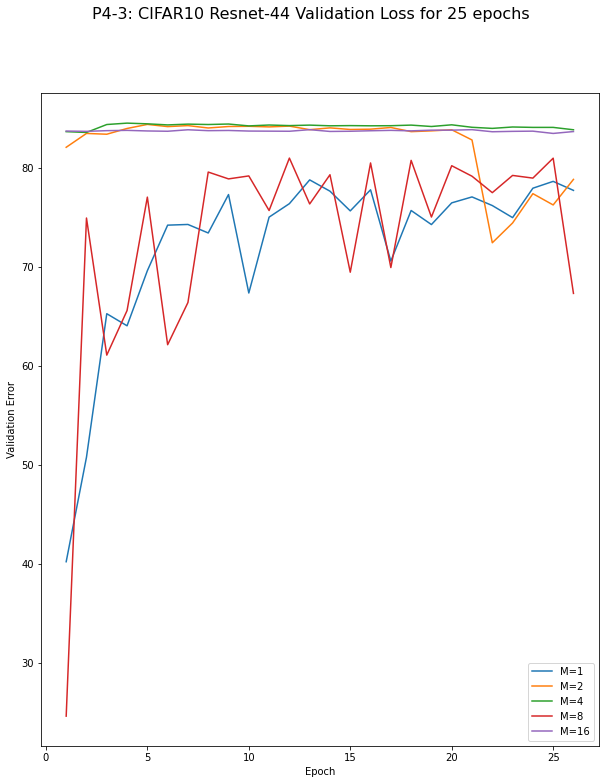

In [60]:
# load the stored json data into dictionary if it doesn't exist
if info_3:
    plot_info = info_3
else:
    plot_info = {}
    for m in M:
      json_file = os.path.join(save_dir,'p43_M{}_datadump.json'.format(m))
      if os.path.isfile(json_file):
          with open(json_file) as json_file: 
              plot_info[m] = json.load(json_file) 
      else:
          print('File \'{}\' does not exist.'.format(json_file))

#####
# performance plots (loss)
#####
# plot
cmap = plt.cm.get_cmap('jet', 2)
fig3 = plt.figure(figsize=(10,12))
title = "CIFAR10 Resnet-44 Validation Loss for {} epochs".format(epoch_max)
fig3.suptitle('P4-3: {}'.format(title), fontsize=16)
# plotting loss for each method
# ax1 = fig3.add_subplot(2, 1, 1)
# ax1.set_title("Best accuracy: {} = {:.2f}%".format(best[0],best[1]*100))
# plotting loss for each method
ax1 = fig3.add_subplot(1, 1, 1)
# ax1.set_title("Best accuracy: {} = {:.2f}%".format(best[0],best[1]*100))
for i,m in enumerate(plot_info.keys()):
  ax1.plot([None] + plot_info[m]['prec'],'-')
ax1.legend(['M={}'.format(x) for x in list(plot_info.keys())], loc= 0)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Error')
plt.show()

***
# Problem 5: Universal Approximators: Depth Vs. Width (30)

The Eggholder function is defined as:
$$
f(x_{1},x_{2})=-(x_{2}+47)\sin\Big(\sqrt{\big|\frac{x_{1}}{2}+(x_{2}+47)\big|}\Big)-x_{1}\sin\Big(\sqrt{\big|x_{1}-(x_{2}+47)\big|}\Big)
$$

The code below implements the Eggholder function and creates a training and testing dataset.



In [63]:
# prepare data
def f(x):
    a = -(x[:,1]+47)*np.sin(np.sqrt(np.abs(x[:,0]/2+(x[:,1]+47))))
    b = -x[:,0]*np.sin(np.sqrt(np.abs(x[:,0]-(x[:,1]+47))))
    return a+b

dsize = int(1e5) # total dataset size
seed = 6998 # random state seed

# y = 

######
# create training/testing data
######
x1,x2 = [np.sort(np.random.uniform(-512,512,dsize)),
         np.sort(np.random.uniform(-512,512,dsize))]

x1_train, x1_test, x2_train, x2_test = train_test_split(x1,x2, 
                                   test_size = 0.2, 
                                   random_state = seed)

# final datasets
x_train = np.column_stack((x1_train, x2_train))
y_train = f(x_train) + np.random.normal(0,0.3)
x_test = np.column_stack((x1_test, x2_test))
y_test = f(x_test)

input_shape = x_train.shape

## 5.1 Hidden Layer Budget of 512

Th code below implements the 1, 2, and 3 layer netwroks with he default framework hyperparameters. A random normalization is added.



In [80]:
hidden_unit_max = 512
batch_size = 1000
n_epochs = 5# 2000

nn1 = [16,32,64,128,256,512]
nn2 = [(16,16),(16,32),(16,256),(32,32),(32,64),
       (32,256),(64,64),(64,128),(128,128)]
nn3 = [(16,16,16),(32,32,32),(64,64,64),(128,128,128),
       (16,64,256),(16,16,256),(128,128,256)]

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, 
                                    momentum=0.0, 
                                    nesterov=True)

init = initializers.RandomNormal(mean=0.0, stddev=0.005, seed=seed)


def resetInfo(tmp):
  tmp['rmse'] = []
  tmp['params'] = []
  tmp['fit_time'] = []
  tmp['val_time'] = []
  tmp['eval_loss'] = []
  tmp['eval_accuracy'] = []
  tmp['units'] = []
  return tmp

info = {}
################
# 1 layer
################
info['1'] = {}
tmp = resetInfo(info['1'])
for n_units in nn1:
    # create a sequential fully-connected network
    model = Sequential()

    model.add(Flatten()) # input
    # layer 1
    model.add(Dense(n_units,input_shape=input_shape,kernel_initializer=init))
    model.add(Activation(activation='relu'))
    model.add(Dense(1, kernel_initializer=init)) #output 

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.metrics.mean_squared_error,
        metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    
    # train/test
    t0 = time.time() # <-- start clock
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        epochs=n_epochs,
                        verbose=0)
    fit_time = np.around(time.time()-t0,2) # <-- end clock
    
    # evaluate the model
    t0 = time.time() # <-- start clock
    eval = model.evaluate(x_test, y_test, 
                          batch_size=batch_size,
                          verbose=1)
    val_time = np.around(time.time()-t0,2) # <-- end clock
    
    tmp['rmse'].append(history.history['rmse'])
    tmp['params'].append(model.count_params())
    tmp['fit_time'].append(fit_time)
    tmp['val_time'].append(val_time)
    tmp['eval_loss'].append(eval[0])
    tmp['eval_accuracy'].append(eval[1])
    tmp['units'].append(n_units)

################
# 2 layer
################
info['2'] = {}
tmp = resetInfo(info['2'])
for n_units in nn2:
    # create a sequential fully-connected network
    model = Sequential()

    model.add(Flatten()) #input
    # layer 1
    model.add(Dense(n_units[0],input_shape=input_shape,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    # layer 2
    model.add(Dense(n_units[1],input_shape=input_shape,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dense(1, kernel_initializer=init)) #output

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.metrics.mean_squared_error,
        metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    # train/test
    t0 = time.time() # <-- start clock
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        epochs=n_epochs,
                        verbose=0)
    fit_time = np.around(time.time()-t0,2) # <-- end clock
    
    # evaluate the model
    t0 = time.time() # <-- start clock
    eval = model.evaluate(x_test, y_test, 
                          batch_size=batch_size,
                          verbose=1)
    val_time = np.around(time.time()-t0,2) # <-- end clock
    
    tmp['rmse'].append(history.history['rmse'])
    tmp['params'].append(model.count_params())
    tmp['fit_time'].append(fit_time)
    tmp['val_time'].append(val_time)
    tmp['eval_loss'].append(eval[0])
    tmp['eval_accuracy'].append(eval[1])
    tmp['units'].append(n_units)

################
# 3 layer
################
info['3'] = {}
tmp = resetInfo(info['3'])
for n_units in nn3:
    # create a sequential fully-connected network
    model = Sequential()

    model.add(Flatten()) # input
    #layer 1
    model.add(Dense(n_units[0],input_shape=input_shape,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    #layer 2
    model.add(Dense(n_units[1],input_shape=input_shape,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    #layer 3
    model.add(Dense(n_units[2],input_shape=input_shape,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dense(1, kernel_initializer=init)) #output

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.metrics.mean_squared_error,
        metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    # train/test
    t0 = time.time() # <-- start clock
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        epochs=n_epochs,
                        verbose=0)
    fit_time = np.around(time.time()-t0,2) # <-- end clock
    
    # evaluate the model
    t0 = time.time() # <-- start clock
    eval = model.evaluate(x_test, y_test, 
                          batch_size=batch_size,
                          verbose=0)
    val_time = np.around(time.time()-t0,2) # <-- end clock
    
    tmp['rmse'].append(history.history['rmse'])
    tmp['params'].append(model.count_params())
    tmp['fit_time'].append(fit_time)
    tmp['val_time'].append(val_time)
    tmp['eval_loss'].append(eval[0])
    tmp['eval_accuracy'].append(eval[1])
    tmp['units'].append(np.sum(n_units))

20/20 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.0000e+00 - rmse: nan


In [ ]:
#####
# performance plots (loss)
#####
# plot 1
fig3 = plt.figure(figsize=(10,12))
title = "RMSE as a function of total # units"
fig3.suptitle('P5-1: {}'.format(title), fontsize=16)
# plotting loss for each method
ax1 = fig3.add_subplot(1, 1, 1)
# ax1.set_title("Best accuracy: {} = {:.2f}%".format(best[0],best[1]*100))
for i,m in enumerate(info.keys()):
  ax1.plot(info[m]['units'],info[m]['rmse'],'-')
ax1.legend(['M={}'.format(x) for x in list(plot_info.keys())], loc= 0)
ax1.set_xlabel('# of Hidden Units')
ax1.set_ylabel('RMSE')
plt.show()

# plot 2
fig3 = plt.figure(figsize=(10,12))
title = "RMSE as a function of total # parameters"
fig3.suptitle('P5-1: {}'.format(title), fontsize=16)
# plotting loss for each method
ax1 = fig3.add_subplot(1, 1, 1)
# ax1.set_title("Best accuracy: {} = {:.2f}%".format(best[0],best[1]*100))
for i,m in enumerate(info.keys()):
  ax1.plot(info[m]['units'],info[m]['parms'],'-')
ax1.legend(['M={}'.format(x) for x in list(plot_info.keys())], loc= 0)
ax1.set_xlabel('# of Parameters')
ax1.set_ylabel('RMSE')
plt.show()

## 5.2 Tradeoff between parameters and RMSE as network goes deeper

__Answer: If I were able to get the model to work, I would imagine that as the network got deeper (but units were unchanged) then the RMSE would go down because the model is able to fit the parameters better, where as for the single layer network would have a higher error. The wall clock time is included in the info.dict() above but it is not accurate due to the failed network... if it were accurate, I'd imagine that as the number parameters increased then the training time would also increase and we would see a tradeoff in training time.__